# Entrega Intermediária

In [49]:
import re
import os
import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk

from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



In [2]:
nltk.download('rslp')

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [3]:
path = './archive'
os.listdir(path)

['olist_orders_dataset.csv',
 'olist_order_reviews_dataset.csv',
 'product_category_name_translation.csv']

In [4]:
df_orders = pd.read_csv(f'{path}/olist_orders_dataset.csv', na_values=['', np.nan])
# df_orders.head()

In [5]:
df_reviews = pd.read_csv(f'{path}/olist_order_reviews_dataset.csv', na_values=['', np.nan])
# df_reviews.head()

In [6]:
df = pd.merge(df_reviews, df_orders, on='order_id') 
df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,2018-01-11 15:47:59,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02 00:00:00
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13,8a2e7ef9053dea531e4dc76bd6d853e6,delivered,2018-02-28 12:25:19,2018-02-28 12:48:39,2018-03-02 19:08:15,2018-03-09 23:17:20,2018-03-14 00:00:00
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24,e226dfed6544df5b7b87a48208690feb,delivered,2018-02-03 09:56:22,2018-02-03 10:33:41,2018-02-06 16:18:28,2018-02-16 17:28:48,2018-03-09 00:00:00
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,de6dff97e5f1ba84a3cd9a3bc97df5f6,delivered,2017-04-09 17:41:13,2017-04-09 17:55:19,2017-04-10 14:24:47,2017-04-20 09:08:35,2017-05-10 00:00:00
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,5986b333ca0d44534a156a52a8e33a83,delivered,2018-02-10 10:59:03,2018-02-10 15:48:21,2018-02-15 19:36:14,2018-02-28 16:33:35,2018-03-09 00:00:00


In [7]:
df_comments = df[['review_score', 'review_comment_message']].dropna()
df_comments.head()

,review_score,review_comment_message
3,5,Recebi bem antes do prazo estipulado.
4,5,Parabéns lojas lannister adorei comprar pela I...
9,4,aparelho eficiente. no site a marca do aparelh...
12,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
15,5,"Vendedor confiável, produto ok e entrega antes..."


In [8]:
count_review_message = df[df['review_comment_message'].notnull()].count()
count_reviw_title = df[df['review_comment_title'].notnull()].count()
print(f"Número de mensagens de reviews preenchidas: {count_review_message['review_comment_message']}")
print(f"Número de títulos de reviews preenchidos: {count_reviw_title['review_comment_title']}")

Número de mensagens de reviews preenchidas: 40977
Número de títulos de reviews preenchidos: 11568


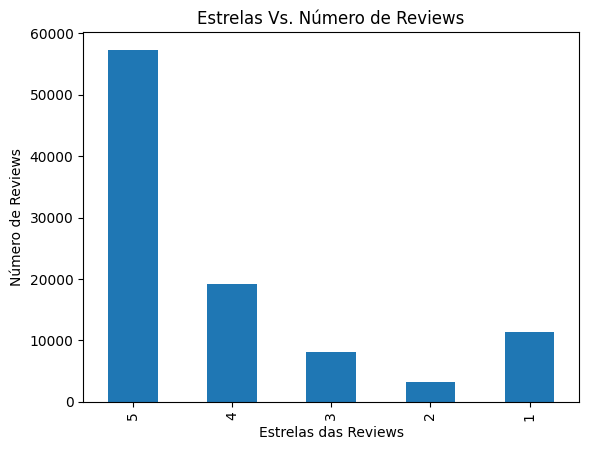

In [9]:
stars = df['review_score'].value_counts()
stars = stars.reindex([5, 4, 3, 2, 1])
stars.plot(kind='bar')

plt.xlabel('Estrelas das Reviews')
plt.ylabel('Número de Reviews')
plt.title('Estrelas Vs. Número de Reviews')
plt.show()

In [10]:
count_review_message = df[df['review_comment_message'].notnull()].count()
count_reviw_title = df[df['review_comment_title'].notnull()].count()
print(f"Número de mensagens de reviews preenchidas: {count_review_message['review_comment_message']}")
print(f"Número de títulos de reviews preenchidos: {count_reviw_title['review_comment_title']}")

Número de mensagens de reviews preenchidas: 40977
Número de títulos de reviews preenchidos: 11568


REGULAR EXPRESSIONS

In [11]:
reviews = list(df_comments['review_comment_message'].values)

In [12]:
def re_breakline(text_list):
    return [re.sub('[\n\r]', ' ', str(r)) for r in text_list]

reviews_breakline = re_breakline(reviews)
# df_comments['re_breakline'] = reviews_breakline

In [13]:
def re_hiperlinks(text_list):
    pattern = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return [re.sub(pattern, ' link ', r) for r in text_list]

reviews_hiperlinks = re_hiperlinks(reviews_breakline)
# df_comments['re_hiperlinks'] = reviews_hiperlinks

In [14]:
def re_dates(text_list):
    pattern = '([0-2][0-9]|(3)[0-1])(\/|\.)(((0)[0-9])|((1)[0-2]))(\/|\.)\d{2,4}'
    return [re.sub(pattern, ' data ', r) for r in text_list]

reviews_dates = re_dates(reviews_hiperlinks)
# df_comments['re_dates'] = reviews_dates

In [15]:
def re_money(text_list):
    pattern = '[R]{0,1}\$[ ]{0,}\d+(,|\.)\d+'
    return [re.sub(pattern, ' dinheiro ', r) for r in text_list]

reviews_money = re_money(reviews_dates)
# df_comments['re_money'] = reviews_money

In [16]:
def re_numbers(text_list):
    return [re.sub('[0-9]+', ' numero ', r) for r in text_list]

reviews_numbers = re_numbers(reviews_money)
# df_comments['re_numbers'] = reviews_numbers

In [17]:
def re_negation(text_list):
    return [re.sub('([nN][ãÃaA][oO]|[ñÑ]| [nN] )', ' negação ', r) for r in text_list]

reviews_negation = re_negation(reviews_numbers)
# df_comments['re_negation'] = reviews_negation

In [18]:
def re_special_chars(text_list):
    return [re.sub('\W', ' ', r) for r in text_list]

reviews_special_chars = re_special_chars(reviews_negation)
# df_comments['re_special_chars'] = reviews_special_chars

In [19]:
def re_whitespaces(text_list):
    white_spaces = [re.sub('\s+', ' ', r) for r in text_list]
    white_spaces_end = [re.sub('[ \t]+$', '', r) for r in white_spaces]
    return white_spaces_end

reviews_whitespaces = re_whitespaces(reviews_special_chars)
# df_comments['re_whitespaces'] = reviews_whitespaces

STOPWORDS

In [20]:
# download stopwords em português
stopwords_url = "https://gist.githubusercontent.com/alopes/5358189/raw/2107d809cca6b83ce3d8e04dbd9463283025284f/stopwords.txt"
stopwords_list = urllib.request.urlopen(stopwords_url).read().decode()
stopwords = stopwords_list.split()

# stopwords

In [21]:
def stopwords_removal(text, cached_stopwords):
    return [c.lower() for c in str(text).split() if c.lower() not in cached_stopwords]

reviews_stopwords = [' '.join(stopwords_removal(review, stopwords)) for review in reviews_whitespaces]
# df_comments['stopwords_removed'] = reviews_stopwords

STEMMING

In [22]:
# Defining a function to remove the stopwords and to lower the comments
def stemming_process(text, stemmer=RSLPStemmer()):
    return [stemmer.stem(c) for c in text.split()] 

reviews_stemmer = [' '.join(stemming_process(review)) for review in reviews_stopwords]
# df_comments['stemming'] = reviews_stemmer

In [23]:
def extract_features_from_corpus(corpus, vectorizer, df=False):
    corpus_features = vectorizer.fit_transform(corpus).toarray()
    features_names = vectorizer.get_feature_names_out()
    
    df_corpus_features = None
    if df:
        df_corpus_features = pd.DataFrame(corpus_features, columns=features_names)
    
    return corpus_features, df_corpus_features

In [24]:
count_vectorizer = CountVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=stopwords)

countv_features, df_countv_features = extract_features_from_corpus(reviews_stemmer, count_vectorizer, df=True)
print(f'Shape of countv_features matrix: {countv_features.shape}\n')
print(f'Example of DataFrame of corpus features:')

df_countv_features.head()

Shape of countv_features matrix: (40977, 300)

Example of DataFrame of corpus features:


,abr,acab,ach,acontec,acord,ador,adquir,agor,aguard,aind,...,vei,vem,vend,ver,vez,vier,volt,vou,ótim,únic
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [25]:
vectorizer = TfidfVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=stopwords)

features, df_features = extract_features_from_corpus(reviews_stemmer, vectorizer, df=True)
print(f'Shape of countv_features matrix: {features.shape}\n')
print(f'Example of DataFrame of corpus features:')

df_features.head()

Shape of countv_features matrix: (40977, 300)

Example of DataFrame of corpus features:


,abr,acab,ach,acontec,acord,ador,adquir,agor,aguard,aind,...,vei,vem,vend,ver,vez,vier,volt,vou,ótim,únic
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.319302,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.196792,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.461052,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


PIPELINE

In [30]:
# Class for regular expressions application
class ApplyRegex(BaseEstimator, TransformerMixin):
    
    def __init__(self, regex_transformers):
        self.regex_transformers = regex_transformers
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # Applying all regex functions in the regex_transformers dictionary
        for regex_name, regex_function in self.regex_transformers.items():
            X = regex_function(X)
            
        return X

# Class for stopwords removal from the corpus
class StopWordsRemoval(BaseEstimator, TransformerMixin):
    
    def __init__(self, text_stopwords):
        self.text_stopwords = text_stopwords
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return [' '.join(stopwords_removal(comment, self.text_stopwords)) for comment in X]

# Class for apply the stemming process
class StemmingProcess(BaseEstimator, TransformerMixin):
    
    def __init__(self, stemmer):
        self.stemmer = stemmer
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return [' '.join(stemming_process(comment, self.stemmer)) for comment in X]
    
# Class for extracting features from corpus
class TextFeatureExtraction(BaseEstimator, TransformerMixin):
    
    def __init__(self, vectorizer):
        self.vectorizer = vectorizer
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return self.vectorizer.fit_transform(X).toarray()

In [31]:
# Defining regex transformers to be applied
regex_transformers = {
    'break_line': re_breakline,
    'hiperlinks': re_hiperlinks,
    'dates': re_dates,
    'money': re_money,
    'numbers': re_numbers,
    'negation': re_negation,
    'special_chars': re_special_chars,
    'whitespaces': re_whitespaces
}

# Defining the vectorizer to extract features from text
vectorizer = TfidfVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=stopwords)

# Building the Pipeline
text_pipeline = Pipeline([
    ('regex', ApplyRegex(regex_transformers)),
    ('stopwords', StopWordsRemoval(stopwords)),
    ('stemming', StemmingProcess(RSLPStemmer())),
    ('text_features', TextFeatureExtraction(vectorizer))
])

text_pipeline

Pipeline(steps=[('regex',
                 ApplyRegex(regex_transformers={'break_line': <function re_breakline at 0x000002144F40B6D0>,
                                                'dates': <function re_dates at 0x00000214747AB250>,
                                                'hiperlinks': <function re_hiperlinks at 0x00000214747AACB0>,
                                                'money': <function re_money at 0x00000214747ABB50>,
                                                'negation': <function re_negation at 0x00000214749E1F30>,
                                                'numbers': <function re_numbers at 0x0...
                 StemmingProcess(stemmer=<nltk.stem.rslp.RSLPStemmer object at 0x00000214747124A0>)),
                ('text_features',
                 TextFeatureExtraction(vectorizer=TfidfVectorizer(max_df=0.8,
                                                                  max_features=300,
                                                                  min_df=7,
                                                                  stop_words=['de',
                                                                              'a',
                                                                              'o',
                                                                              'que',
                                                                              'e',
                                                                              'do',
                                                                              'da',
                                                                              'em',
                                                                              'um',
                                                                              'para',
                                                                              'é',
                                                                              'com',
                                                                              'não',
                                                                              'uma',
                                                                              'os',
                                                                              'no',
                                                                              'se',
                                                                              'na',
                                                                              'por',
                                                                              'mais',
                                                                              'as',
                                                                              'dos',
                                                                              'como',
                                                                              'mas',
                                                                              'foi',
                                                                              'ao',
                                                                              'ele',
                                                                              'das',
                                                                              'tem',
                                                                              'à', ...])))])

PREPARANDO PARA CLASSIFICAÇÃO

In [32]:
# Labelling data
score_map = {
    1: 'negative',
    2: 'negative',
    3: 'positive',
    4: 'positive',
    5: 'positive'
}
df_comments['sentiment_label'] = df_comments['review_score'].map(score_map)

df_comments.head()

,review_score,review_comment_message,sentiment_label
3,5,Recebi bem antes do prazo estipulado.,positive
4,5,Parabéns lojas lannister adorei comprar pela I...,positive
9,4,aparelho eficiente. no site a marca do aparelh...,positive
12,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",positive
15,5,"Vendedor confiável, produto ok e entrega antes...",positive


In [42]:
# Defining X and y 
idx_reviews = df_comments['review_comment_message'].index
score = df_comments['review_score'][idx_reviews].map(score_map)

# Splitting into train and test sets
X = list(df_comments['review_comment_message'][idx_reviews].values)
y = score.apply(lambda x: 1 if x == 'positive' else 0).values

# Applying the pipeline and splitting the data
X_processed = text_pipeline.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=.20, random_state=42)

# Verifying results
print(f'Length of X_train_processed: {len(X_train)} - Length of one element: {len(X_train[0])}')
print(f'Length of X_test_processed: {len(X_test)} - Length of one element: {len(X_test[0])}')

Length of X_train_processed: 32781 - Length of one element: 300
Length of X_test_processed: 8196 - Length of one element: 300


CLASSIFICAÇÃO

In [43]:
# Creating an object and training the classifiers
clf_tool = LogisticRegression(
    C=15, 
    penalty='l1',
    class_weight='balanced',
    random_state=42,
    solver='liblinear'
)
clf_tool.fit(X_train, y_train)

LogisticRegression(C=15, class_weight='balanced', penalty='l1', random_state=42,
                   solver='liblinear')

Accuracy: 0.8726207906295754
Confusion Matrix:
 [[1969  182]
 [ 862 5183]]
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.92      0.79      2151
           1       0.97      0.86      0.91      6045

    accuracy                           0.87      8196
   macro avg       0.83      0.89      0.85      8196
weighted avg       0.90      0.87      0.88      8196



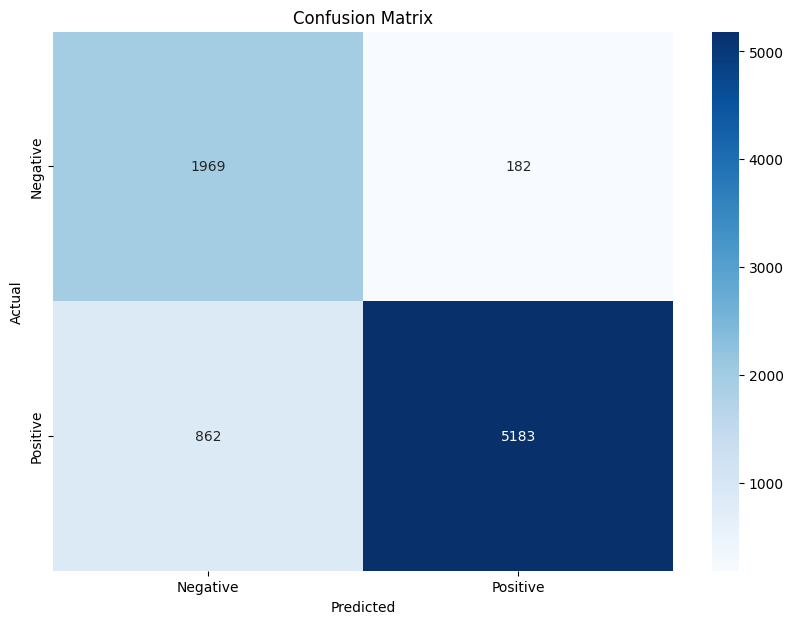

In [51]:
y_pred = clf_tool.predict(X_test)

# Evaluating the model's performance
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Displaying the results
# print("Accuracy:", accuracy)
# print("Confusion Matrix:\n", confusion)
# print("Classification Report:\n", report)

plt.figure(figsize=(10, 7))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()